In [160]:
import re

import numpy as np
import pandas
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples

sns.set()

In [161]:
def get_model_name(path):
    return re.sub('.csv', '', re.sub("^.*/", '', path))

In [162]:
columns = ["timestamp", "seed", "env", "levelid", "move_limit", "click_limit", "objectives", "moves_performed",
           "clicks_performed", "objectives_achieved", "reward"]
eval_files = glob.glob("logs/eval/*.csv")
eval_data = [{'name': get_model_name(f), 'dataframe': pandas.read_csv(f, header=0, names=columns, index_col=False)} for
             f in eval_files]

for ev in eval_data:
    ev['dataframe']['completed'] = ev['dataframe']['objectives'] == ev['dataframe']['objectives_achieved']
    ev['dataframe']['completed_limit'] = ev['dataframe'].apply(
        lambda r: r['completed'] and r['moves_performed'] <= r['move_limit'], axis=1)

players_data = pandas.read_csv('logs/players_data_101-200.csv', index_col=False)
move_limits = players_data.groupby('levelid').min()['move_limit']
players_data['completed_limit'] = players_data.apply(
    lambda r: r['completed'] and r['moves_performed'] <= move_limits[r['levelid']], axis=1)

eval_data.append(
    {'name': 'players_data', 'dataframe': players_data.drop('userid', axis=1)})

for ev in eval_data:
    ev['dataframe']['relative_moves_performed'] = ev['dataframe']['moves_performed'] / ev['dataframe']['move_limit']

## Completion Rate (300+)

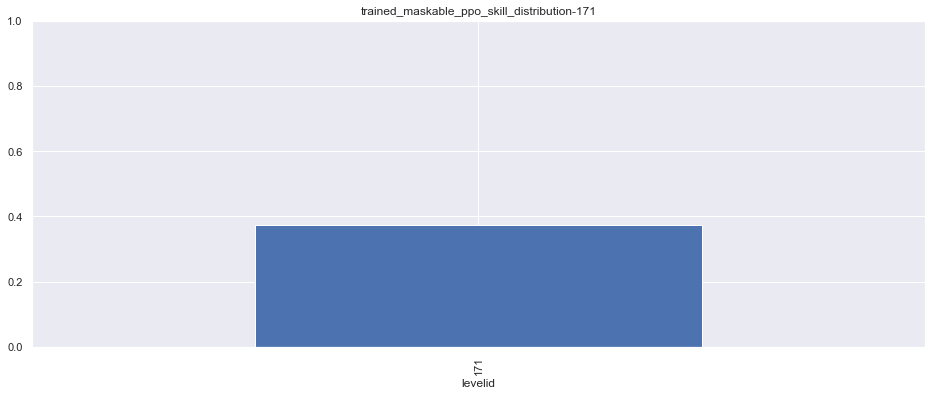

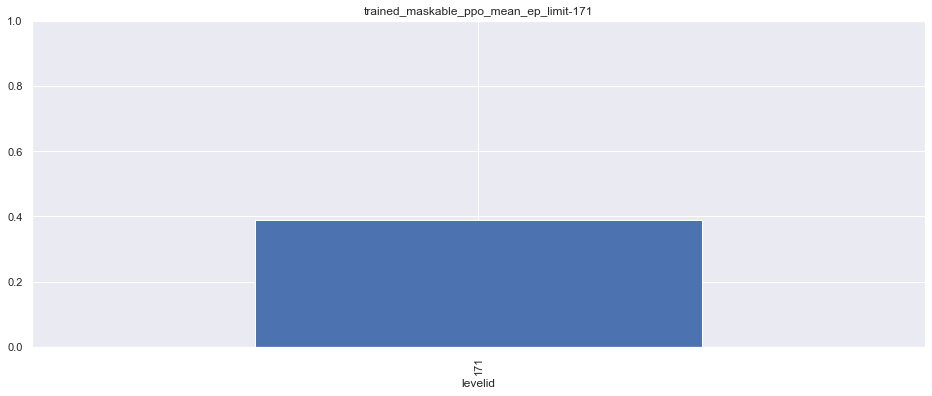

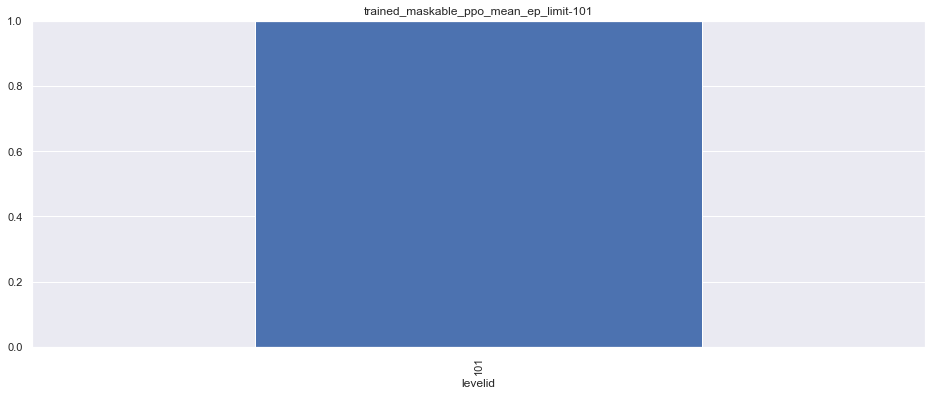

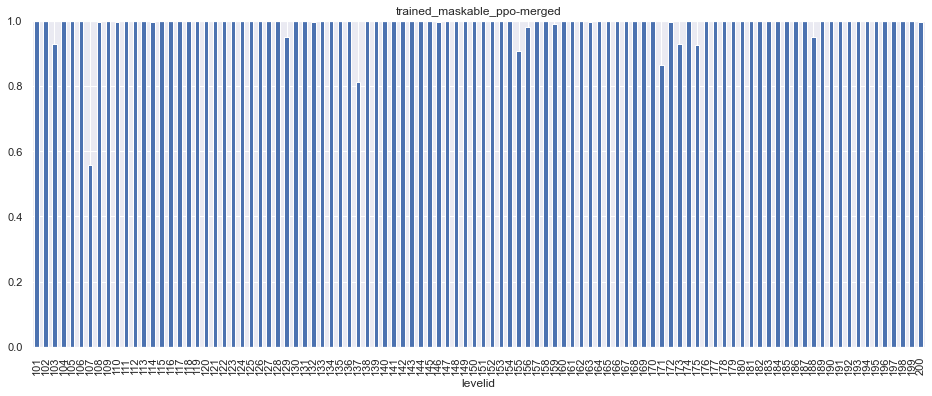

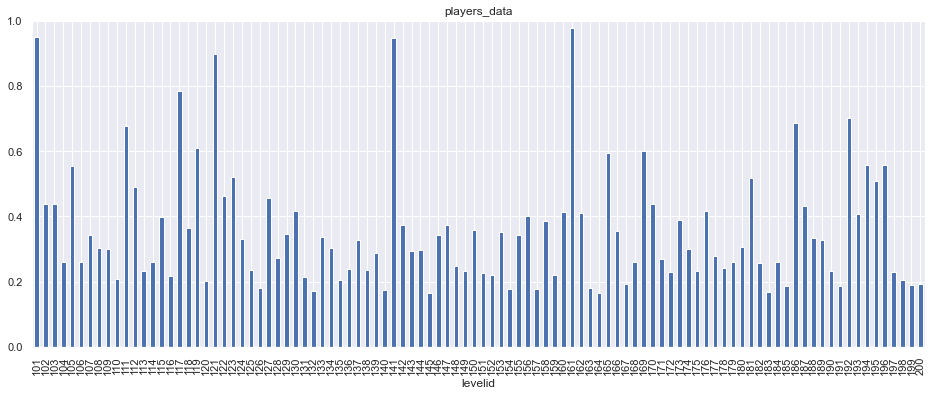

In [163]:
for ev in eval_data:
    pass_rate = ev['dataframe'].groupby('levelid').aggregate('mean')['completed']
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    plt.ylim((0, 1))
    pass_rate.plot.bar()

## Completion Rate (Level Limit)

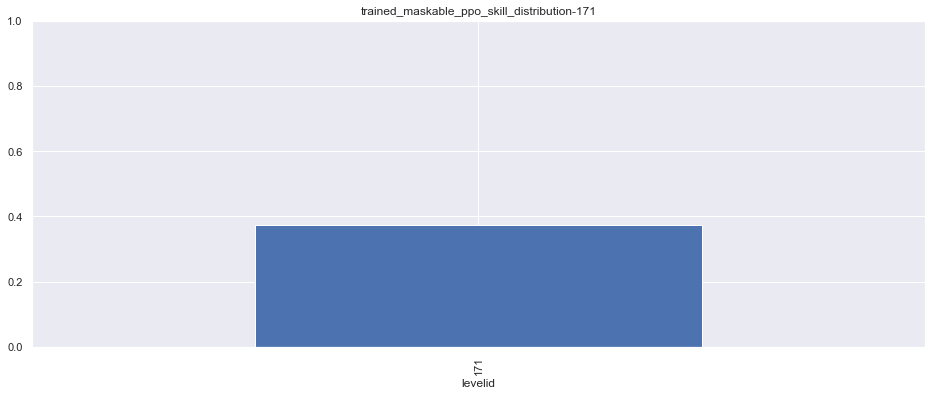

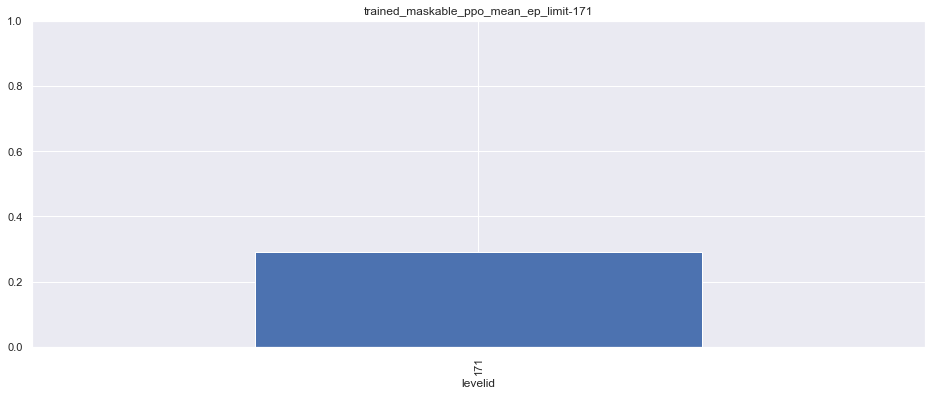

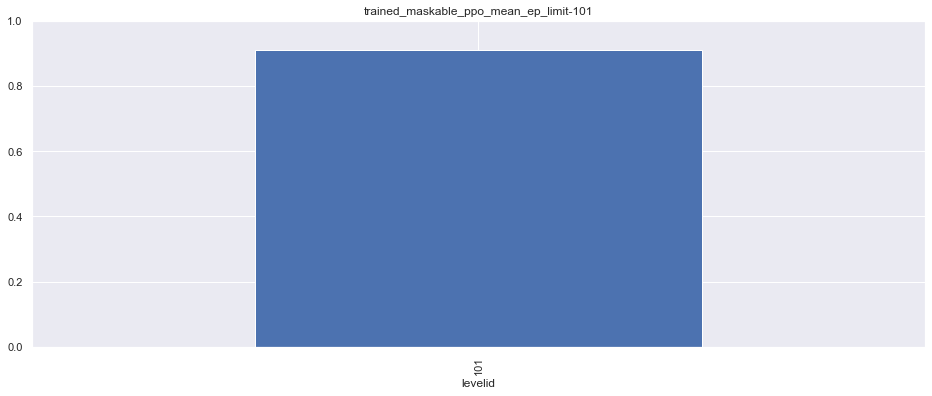

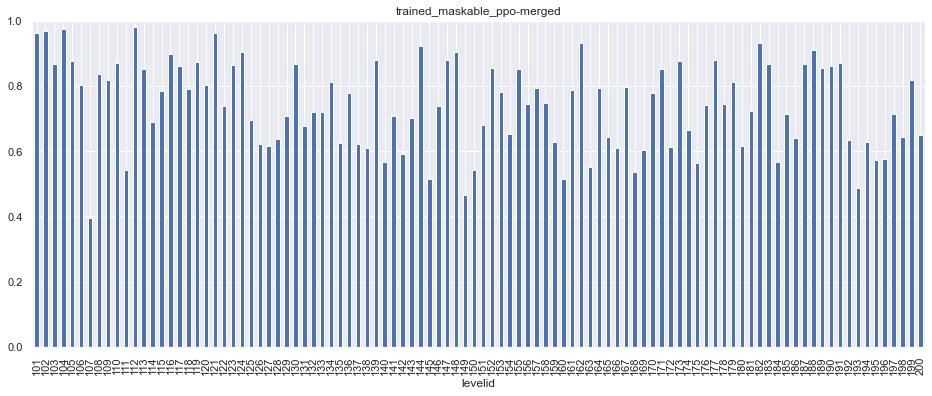

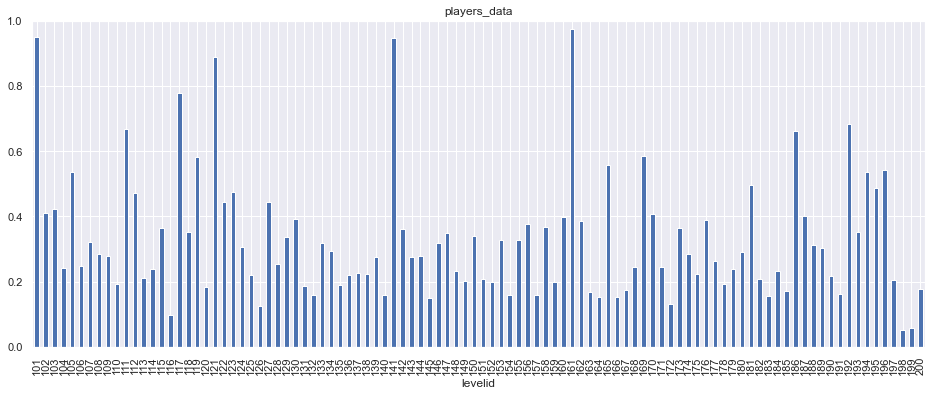

In [164]:
for ev in eval_data:
    pass_rate = ev['dataframe'].groupby('levelid').aggregate('mean')['completed_limit']
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    plt.ylim((0, 1))
    pass_rate.plot.bar()

## Mean moves to complete a level

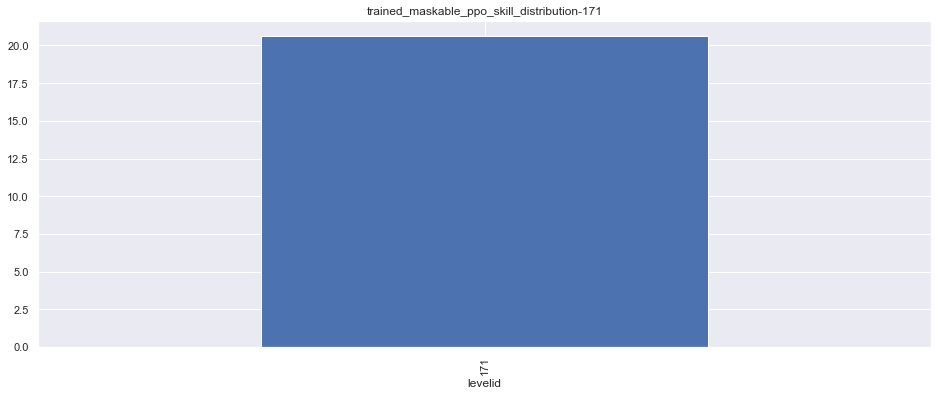

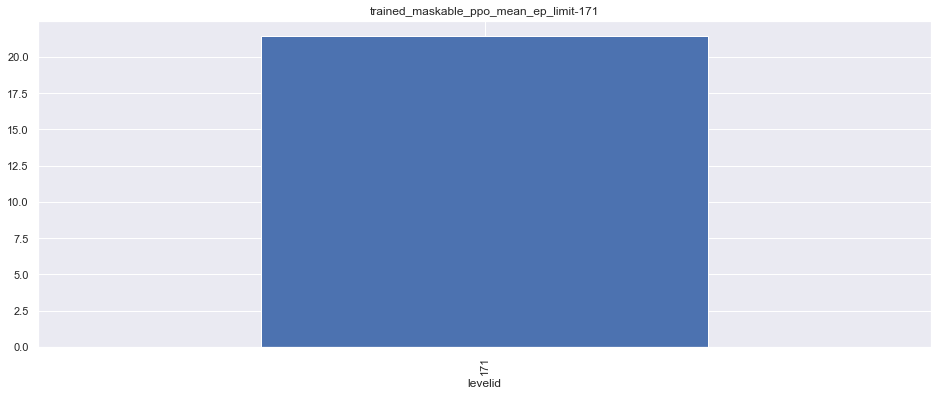

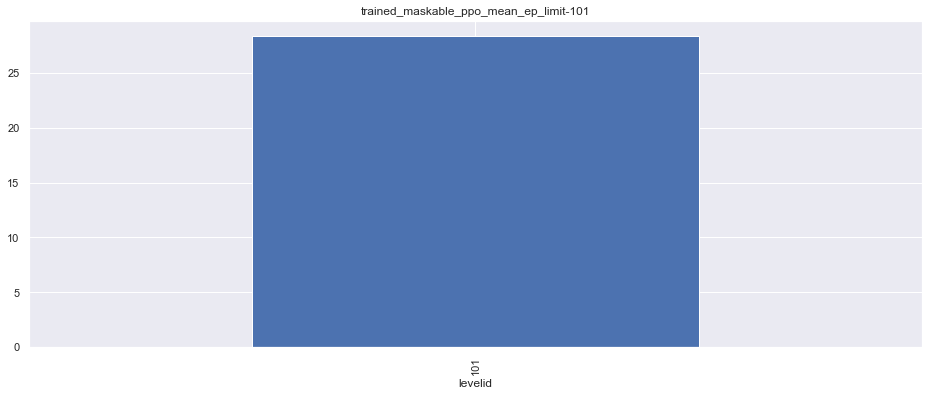

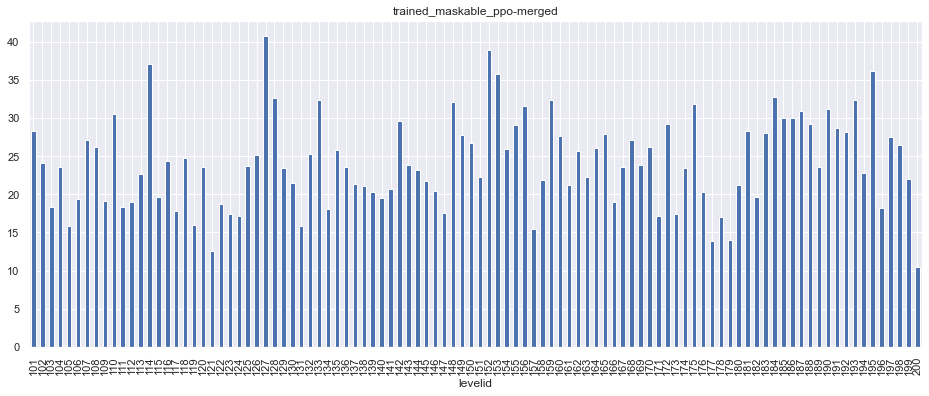

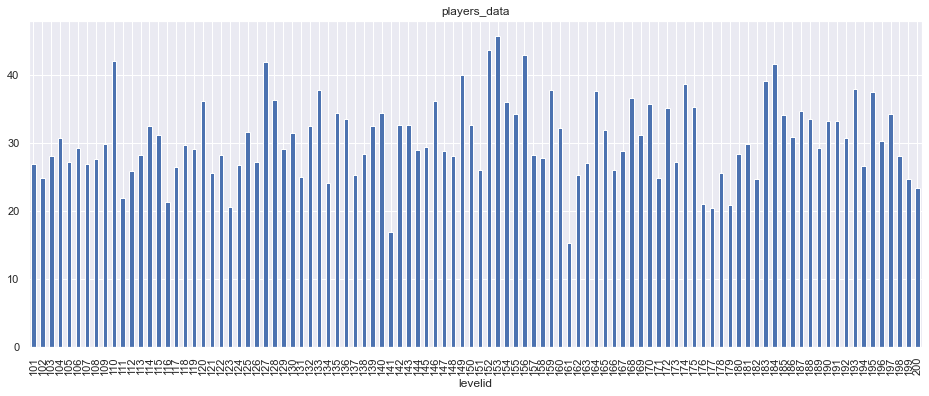

In [165]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed_limit == True]
    completed_runs_stats = completed_runs.groupby("levelid").aggregate('mean')
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    completed_runs_stats['moves_performed'].plot.bar()

## Moves distribution for level 101

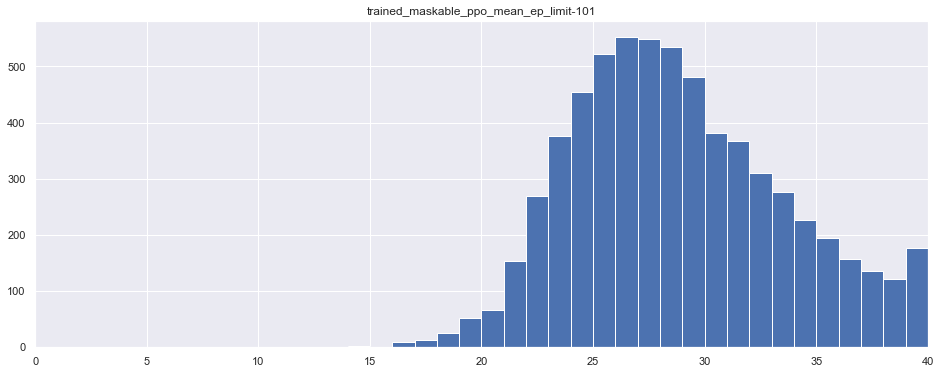

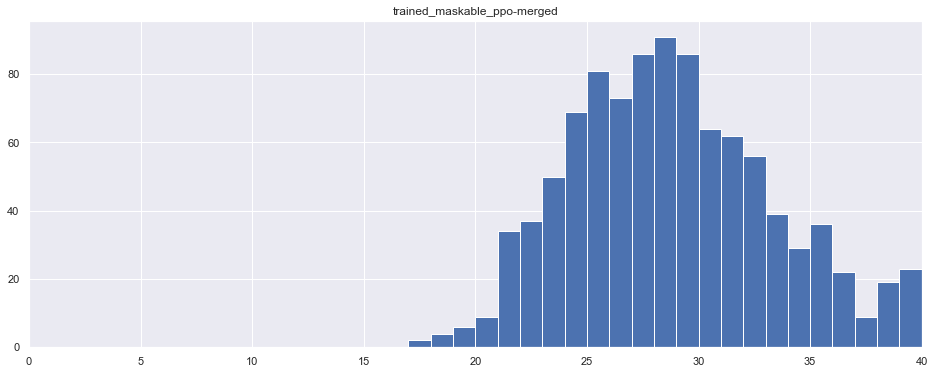

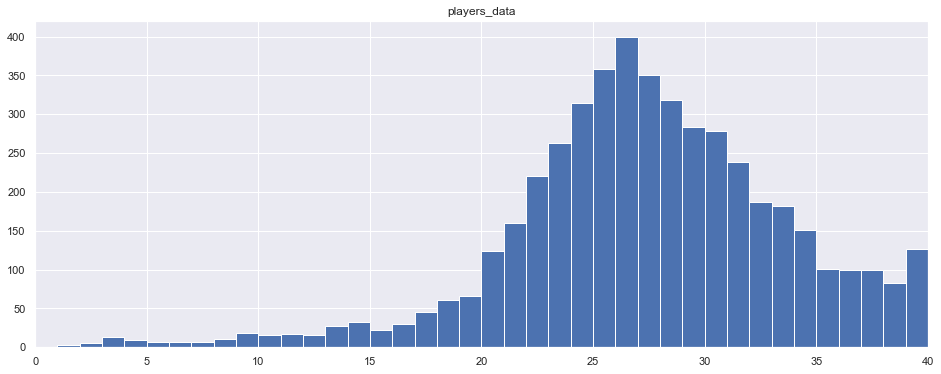

In [166]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed_limit == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 101]
    if len(completed_runs_level) > 0:
        plt.figure(figsize=(16, 6))
        plt.title(ev['name'])
        plt.xlim(0, max(completed_runs_level['moves_performed']))
        completed_runs_level['moves_performed'].hist(
            bins=max(completed_runs_level['moves_performed']) - min(completed_runs_level['moves_performed']))


## QQ-plot

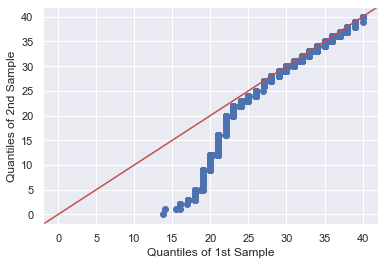

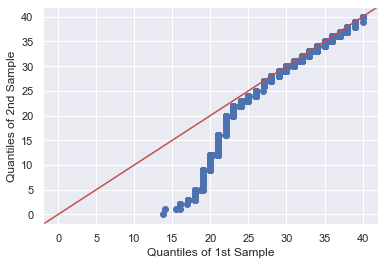

In [167]:
agent_ev = list(filter(lambda a: a['name'] == 'trained_maskable_ppo_mean_ep_limit-101', eval_data))[0][
    'dataframe']
agent_ev = agent_ev[agent_ev['levelid'] == 101]
agent_ev = agent_ev[agent_ev['completed_limit']]

population_ev = list(filter(lambda a: a['name'] == 'players_data', eval_data))[0]['dataframe']
population_ev = population_ev[population_ev['levelid'] == 101]
population_ev = population_ev[population_ev['completed_limit']]
#population_ev = population_ev[population_ev['moves_performed'] >= 15]
qqplot_2samples(agent_ev['moves_performed'], population_ev['moves_performed'], line='45')

## Simulated move limit effect on completion rate for level 101

<BarContainer object of 40 artists>

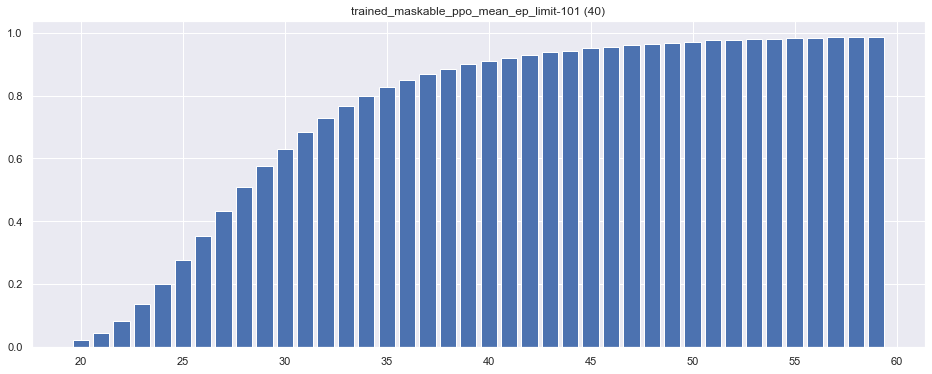

In [168]:
ev = list(filter(lambda a: a['name'] == 'trained_maskable_ppo_mean_ep_limit-101', eval_data))[0]
runs_level = ev['dataframe'][ev['dataframe']['levelid'] == 101]
level_move_limit = runs_level['move_limit'].min()

completion_rate = []
for i in range(-20, 20):
    simulated_limit = level_move_limit + i
    completed = len(runs_level[runs_level['moves_performed'] <= simulated_limit]) / len(runs_level['moves_performed'])
    completion_rate.append({'limit': simulated_limit, 'completion': completed})

data = pandas.DataFrame(completion_rate)
plt.figure(figsize=(16, 6))
plt.title(f"{ev['name']} ({level_move_limit})")
plt.bar(data['limit'], data['completion'])

## Moves distribution for level 171

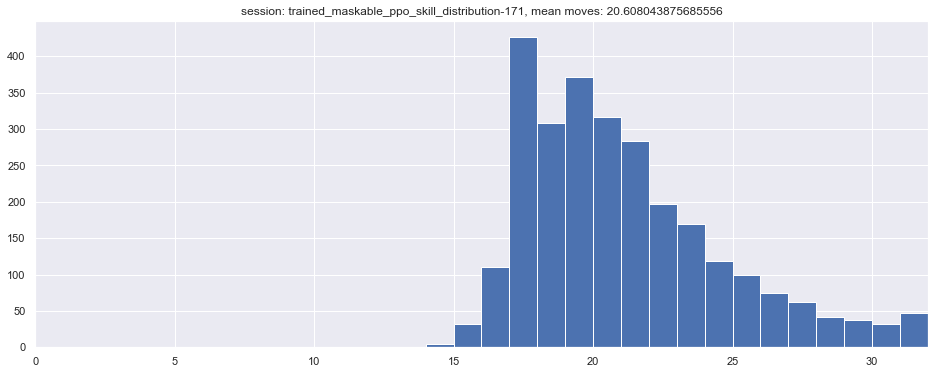

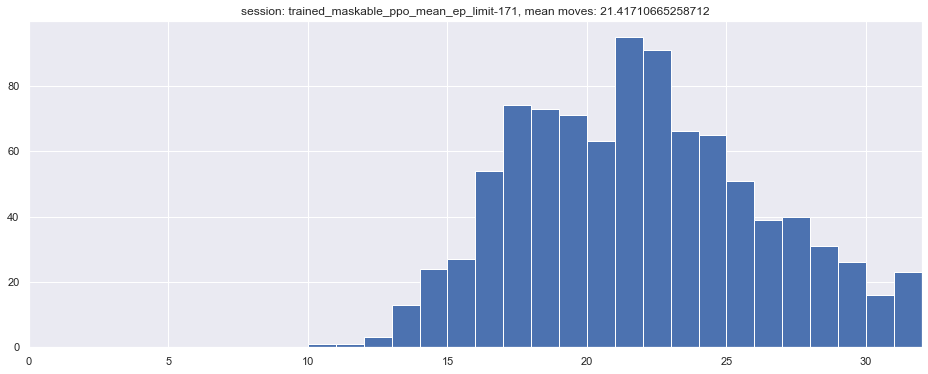

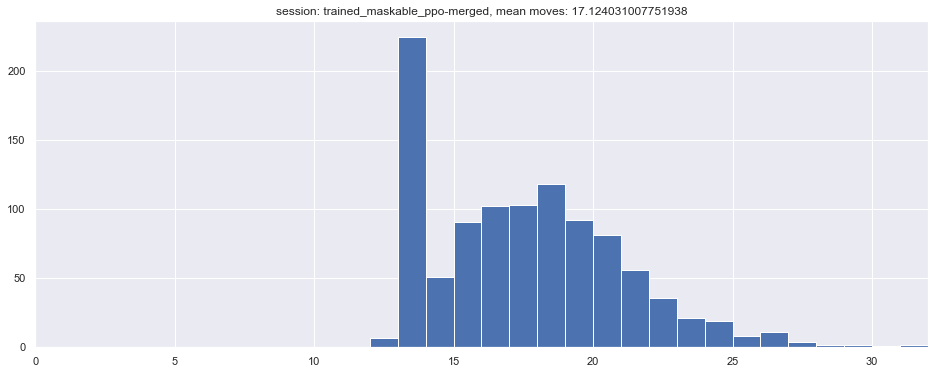

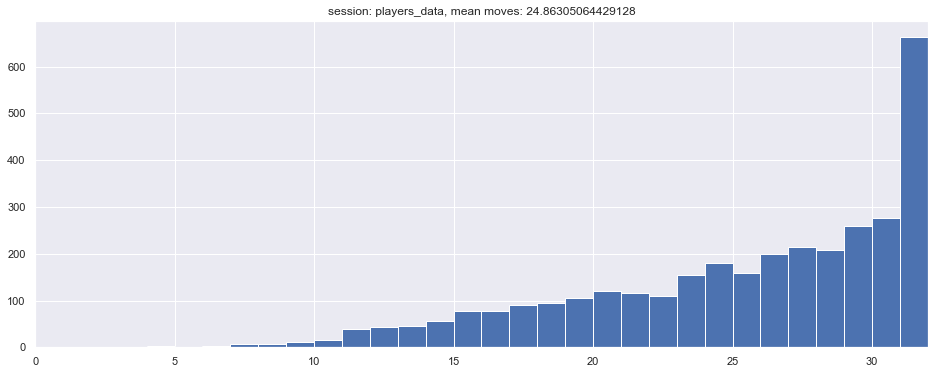

In [172]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed_limit == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 171]
    if len(completed_runs_level) > 0:
        plt.figure(figsize=(16, 6))
        plt.title(f"session: {ev['name']}, mean moves: {completed_runs_level['moves_performed'].mean()}")
        plt.xlim(0, max(completed_runs_level['moves_performed']))
        completed_runs_level['moves_performed'].hist(
            bins=max(completed_runs_level['moves_performed']) - min(completed_runs_level['moves_performed']))

## Player skill distribution for level 171

<AxesSubplot:>

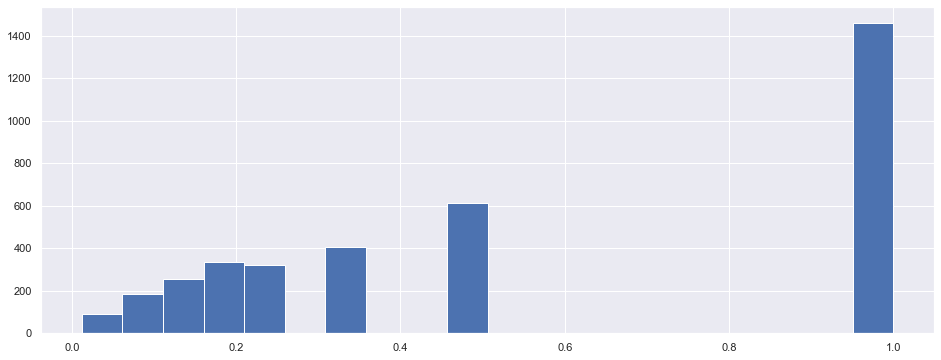

In [170]:
#player_skill = pandas.read_csv("logs/player_skill_171.csv", index_col="userid")
players_data_171 = players_data[players_data["levelid"] == 171]
players_data_171_skill = 1/players_data_171.groupby("userid").count()["levelid"]
players_data_171_skill.hist(bins=20,figsize=(16, 6))
#player_skill["skill"].hist(bins=10,figsize=(16, 6))
